## Import Packages

In [1]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.Draw as Draw
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools

import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.cnn_models import CNNModel as Model

## Curate Dataset

- It is very important to think about how to transform molecule images. Unlike images in computer vision (CV) that can be flipped without affecting the meaning of the images, flipping a molecule image can affect the chirality of molecule, which may be critical to predict molecular properties such as reaction kinetics related properties.

- From my understanding, changing chirality will not affect pKa values. Therefore, the flipping operations are allowed in this notebook.

In [2]:
class MolImageDataset(Dataset):
    def __init__(self, df, transform=None, size=(56, 56)):
        self.all_df = df
        self.transform = transform
        self.size = size
    
    def __getitem__(self, idx):
        mol = self.all_df.iloc[idx]["ROMol"]
        _ = AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=self.size)
        if self.transform:
            img = self.transform(img)
        pka = self.all_df.iloc[idx]["pKa"]
        return img, float(pka)
    
    def __len__(self):
        return self.all_df.shape[0]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((0, 90))
])

In [3]:
infile = "../data/combined_training_datasets_unique.sdf"
all_df = PandasTools.LoadSDF(infile)
name = os.path.splitext(os.path.basename(infile))[0]

[10:06:45] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


## Hyperparameters

In [4]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

datadir = "."
ratio = 0.1
batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

## Split Dataset

In [5]:
# split
nsamples = all_df.shape[0]

print(f"Number of samples: {nsamples}")
val_size = int(nsamples*ratio)
val_size = int(nsamples*ratio)
val_indices = np.random.choice(nsamples, val_size, replace=False)
train_indices = set(range(nsamples)) - set(val_indices.tolist())
train_indices = list(train_indices)

df_train = all_df.iloc[train_indices]
df_test = all_df.iloc[val_indices]
print(f"Size of training set: {df_train.shape[0]}, Size of test set: {df_test.shape[0]}")

## batching
train_loader = DataLoader(MolImageDataset(df_train, transform=transform), \
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MolImageDataset(df_test, transform=transform), \
    batch_size=batch_size, shuffle=False)

Number of samples: 5994
Size of training set: 5395, Size of test set: 599


Show randomly sampled transformed images

<Figure size 200x200 with 0 Axes>

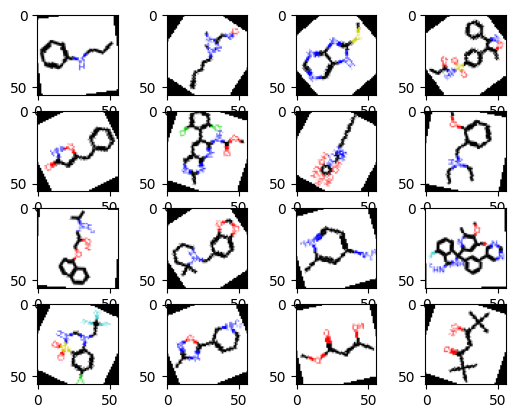

In [6]:
demo = 16
indices = np.random.choice(df_train.shape[0], demo)
train_set = MolImageDataset(df_train, transform=transform)
sampled = [train_set[i] for i in indices]

n = int(np.ceil(np.sqrt(demo)))

plt.figure(figsize=(2, 2))
f, axs = plt.subplots(n, n)
for i in range(demo):
    row = i//n
    col = i%n
    img = sampled[i][0]
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))

## Model

In [7]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred.reshape(-1), y.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred.reshape(-1), y.float())
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [8]:
epochs = 10
lr = 1e-3
in_channel = 3
hidden_channels = [16, 32, 64]
dropout = 0.3
batchnorm = True

model = Model(
    in_channel, 
    hidden_channels,
    kernel_size=(3, 3),
    dropout=dropout,
    activation="ReLU",
    batchnorm=batchnorm,
    residual=True
)

model.to(device)
model = model.to(torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss


train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

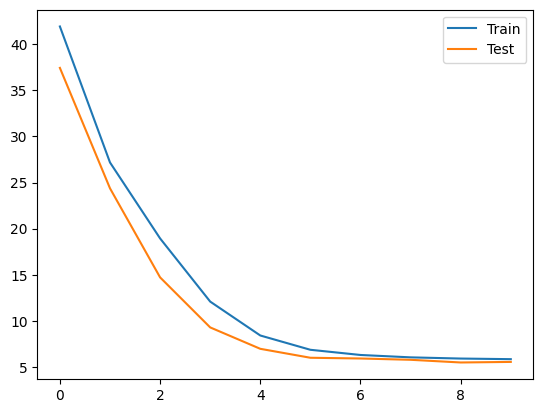

In [9]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(5.4983)


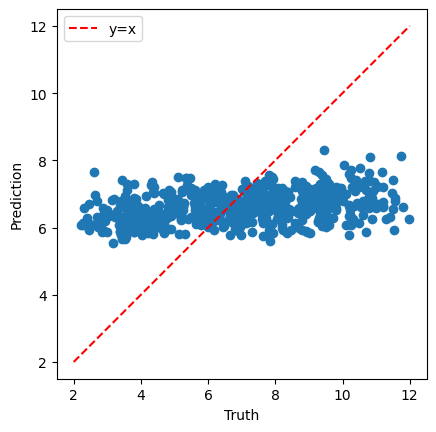

In [10]:
model.eval()
with torch.no_grad():
    truth = []
    pred = []
    for idx, row in df_test.iterrows():
        mol = row["ROMol"]
        _ = AllChem.Compute2DCoords(mol)
        y = float(row["pKa"])
        img = Draw.MolToImage(mol, size=(56, 56))
        img = transform(img)
        p = model(img.unsqueeze(0))
        pred.append(p)
        truth.append(y)
    l = nn.functional.mse_loss(torch.Tensor(pred).float(), torch.Tensor(truth).float())
    print(l)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()